### 用VAE还原一张图

In [ ]:
# https://straycatalliance.org/wp-content/uploads/2022/08/cat-2.png

In [ ]:
import torch
from torchvision import transforms, datasets
from torch import nn, optim
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [ ]:
url = "https://straycatalliance.org/wp-content/uploads/2022/08/cat-2.png"  # 替换为实际图片URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转换为灰度图像
    transforms.Resize((28, 28)),  # 调整大小
    transforms.ToTensor(),  # 转换为张量
])

img_tensor = transform(img).unsqueeze(0)  # 添加批量维度

img_tensor.shape

torch.Size([1, 1, 28, 28])

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # logvar

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

input_dim = 28 * 28
hidden_dim = 400
latent_dim = 20

x = img_tensor.view(-1, 784)
model = VAE(input_dim, hidden_dim, latent_dim)

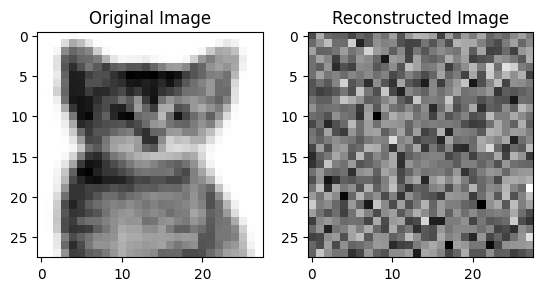

In [ ]:
# 如果不train

model.eval()

with torch.no_grad():
    reconstruction, mu, logvar = model(x)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tensor.view(28, 28).numpy(), cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(reconstruction.view(28, 28).numpy(), cmap='gray')
axs[1].set_title('Reconstructed Image')

plt.show()

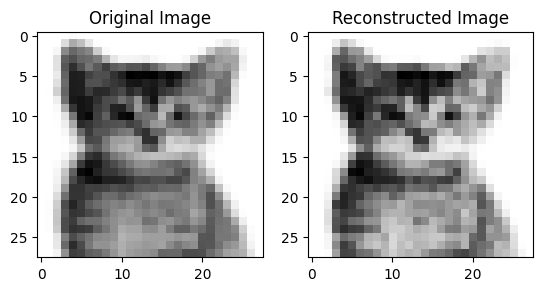

In [ ]:
# TRAIN
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(30):
    train_loss = 0
    optimizer.zero_grad()

    x_hat, mu, logvar = model(x)
    loss = loss_function(x_hat, x, mu, logvar)
    train_loss += loss.item()

    loss.backward()
    optimizer.step()

# TEST
model.eval()
with torch.no_grad():
    reconstruction, mu, logvar = model(x)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tensor.view(28, 28).numpy(), cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(reconstruction.view(28, 28).numpy(), cmap='gray')
axs[1].set_title('Reconstructed Image')

plt.show()

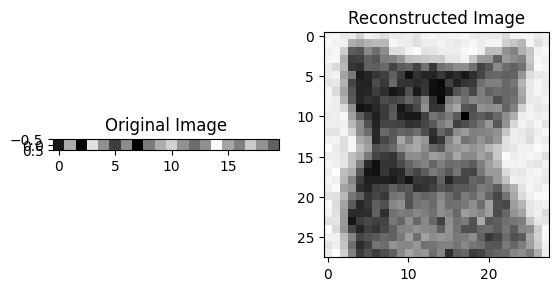

In [ ]:
z_sample = torch.randn(1, latent_dim)
with torch.no_grad():
  generated_image = model.decode(z_sample).view(28, 28)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(z_sample.numpy(), cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(generated_image.numpy(), cmap='gray')
axs[1].set_title('Reconstructed Image')

plt.show()

In [ ]:
random_x = torch.randn(1, 784)
mu, logvar = model.encode(random_x)
generated_image = model.decode(mu).view(28, 28)



torch.Size([1, 20])

In [ ]:
# https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg

url = "https://www.shutterstock.com/image-photo/portrait-beautiful-young-woman-over-260nw-419163175.jpg"  # 替换为实际图片URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 转换为灰度图像
    transforms.Resize((28, 28)),  # 调整大小
    transforms.ToTensor(),  # 转换为张量
])

img_tensor = transform(img).unsqueeze(0)  # 添加批量维度
x2 = img_tensor.view(-1, 784)

model.eval()
with torch.no_grad():
    reconstruction, mu, logvar = model(x2)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tensor.view(28, 28).numpy(), cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(reconstruction.view(28, 28).numpy(), cmap='gray')
axs[1].set_title('Reconstructed Image')

plt.show()

torch.Size([1, 784])

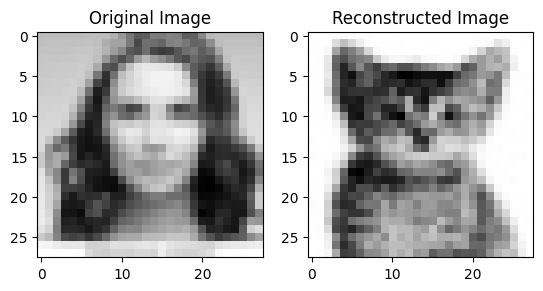